In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, transpile, assemble
from qiskit.circuit import Parameter,ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import EfficientSU2, ZZFeatureMap
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit_machine_learning.circuit.library import RawFeatureVector
from sklearn.preprocessing import OneHotEncoder
from qiskit.algorithms.optimizers import SPSA, GradientDescent, QNSPSA
import numpy as np
import itertools as itr
import matplotlib.pyplot as plt

ACC_COUNT = 10
DIR_val_train = "Encode_data/ang_enc_data_set_trainning_values.csv"
DIR_cls_train = "Encode_data/ang_enc_data_set_trainning_classes.csv"

DIR_val_test = "Encode_data/ang_enc_data_set_test_values.csv"
DIR_cls_test = "Encode_data/ang_enc_data_set_test_classes.csv"

# Circuito

In [15]:
n_qubits = 2

encoding = ZZFeatureMap(feature_dimension=n_qubits, reps=2)

ansatz = EfficientSU2(n_qubits, entanglement='full', reps=2, 
                        insert_barriers=True, name="U(\u03B8)", 
                        parameter_prefix="\u03B8")

encoding.decompose().draw(output="text")
#qc.decompose().draw(output="mpl")

┌───┐┌─────────────┐                                          ┌───┐»
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└─────────────┘└───┘└──────────────────────────────┘└───┘└───┘»
«     ┌─────────────┐                                          
«q_0: ┤ P(2.0*x[0]) ├──■────────────────────────────────────■──
«     ├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐
«q_1: ┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
«     └─────────────┘└───┘└──────────────────────────────┘└───┘

In [16]:
def circuit_parameters(encoding, ansatz, x, thetas, self_encoding=False):
    parameters = {}
    if self_encoding:
        for i, p in enumerate(list(encoding.parameters)):
            parameters[p] = x[i]

    else:
        for i, p in enumerate(list(encoding.ordered_parameters)):
            parameters[p] = x[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = thetas[i]
    return parameters

In [17]:

def train(qc, encoding, ansatz, train_data, train_labels, self_encoding=False, lr=None, initial_point=None):
        # Callback function for optimiser for plotting purposes
        def store_intermediate_result(evaluation, parameter, cost, 
                                stepsize, accept):
                evaluations.append(evaluation)
                parameters.append(parameter)
                costs.append(cost)

        # Set up the optimization

        parameters = []
        costs = []
        evaluations = []

        if lr is not None:
                optimizer = SPSA(maxiter=200 , learning_rate=lr, perturbation=0.01, callback=store_intermediate_result)
        else:
                optimizer = SPSA(maxiter=200, callback=store_intermediate_result)

        if initial_point is not None:
                initial_point = initial_point
        else:      
                initial_point = np.random.random(ansatz.num_parameters)

        objective_function = lambda variational: cost_function(qc,encoding, ansatz,
                train_data, train_labels, variational, self_encoding=self_encoding)
        
        # Run the optimization
        opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function, initial_point=initial_point)

        return opt_var, opt_value , parameters, costs, evaluations 

In [24]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]
    
    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [classification(results.get_counts(c)) for c in circuits]
    cost = np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost {cost}")
    return cost

In [25]:
#%%script echo skipping
def basis_states_probs(counts, shots=1024, decimal=False, n_qubits=1):
    
    """
    Retorna as probabilidades de cada estado
    """
    
    probs = []
   
    if decimal:
        basis_states = list(range(2**n_qubits))
    else:
        basis_states = [np.binary_repr(i,width=n_qubits) for i in range(2**n_qubits)]

    for b in basis_states:
        c = counts.get(b)
        if c is None:
            probs.append(0)
        else:
            probs.append(counts[b]/shots)
    
    return probs


def classification(counts, shots=1024, label=True):
    
    def count_ones(string):
        r = 0
        for char in string:
            if char == "1":
                r+=1
        return r
    
    def label_assign(exp_val):
        if exp_val >= 0:
            r = 1
        else:
            r = -1
        return r

    probs = basis_states_probs(counts, n_qubits=n_qubits)
    states = ["".join(seq) for seq in itr.product("01", repeat=n_qubits)]
    
    exp_val = 0
    for state, prob in zip(states, probs):
        #print(prob, state)
        exp_val += ((-1)**(count_ones(state)%2))*prob
    
    #print(f"Valor expectávlel {exp_val}, Label {label_assign(exp_val)} ")
    if label:
        return label_assign(exp_val)
    else:
        return exp_val
    
def loss_function(y,y_hat):
    #print(f"Loss {y}-{y_hat}**2")
    #print(f"Loss {(y-y_hat)**2}")
    return (y-y_hat) * (y-y_hat)

In [26]:
opt_var1, opt_value1 , parameters, costs, evaluations = train(qc, 
                                                             encoding, 
                                                             ansatz,
                                                             train_data, 
                                                             train_labels, 
                                                             self_encoding=True, 
                                                             initial_point=opt_var1)

Cost 1.05
Cost 1.05
Cost 0.95
Cost 0.9
Cost 0.8
Cost 1.35
Cost 1.0
Cost 0.75
Cost 1.15
Cost 1.1
Cost 1.05
Cost 1.1
Cost 0.9
Cost 1.05
Cost 1.1
Cost 1.15
Cost 0.85
Cost 1.15
Cost 1.05
Cost 1.05
Cost 1.3
Cost 1.15
Cost 0.8
Cost 1.3
Cost 0.95
Cost 1.0
Cost 1.25
Cost 1.4
Cost 0.9
Cost 0.95
Cost 1.15
Cost 1.15
Cost 1.1
Cost 1.0
Cost 1.0
Cost 1.2
Cost 1.45
Cost 0.8
Cost 0.9
Cost 1.35
Cost 0.8
Cost 1.05
Cost 1.05
Cost 1.1
Cost 1.15
Cost 1.2
Cost 0.85
Cost 1.0
Cost 1.15
Cost 0.9
Cost 1.05
Cost 0.95
Cost 1.85
Cost 1.85
Cost 1.7
Cost 2.0
Cost 2.05
Cost 2.1
Cost 2.0
Cost 1.85
Cost 2.15
Cost 1.8
Cost 1.85
Cost 1.8
Cost 1.9
Cost 1.75
Cost 1.65
Cost 1.9
Cost 1.75
Cost 2.05
Cost 1.95
Cost 2.0
Cost 1.85
Cost 1.95
Cost 1.25
Cost 2.0
Cost 2.0
Cost 1.3
Cost 1.9
Cost 1.75
Cost 1.8
Cost 2.1
Cost 1.35
Cost 1.25
Cost 1.7
Cost 1.75
Cost 1.65
Cost 1.35
Cost 1.6
Cost 1.1
Cost 1.65
Cost 1.55
Cost 1.4
Cost 1.95
Cost 1.7
Cost 1.65
Cost 1.6
Cost 1.6
Cost 1.75
Cost 1.6
Cost 1.55
Cost 1.65
Cost 1.95
Cost 1.75
Cost 1.

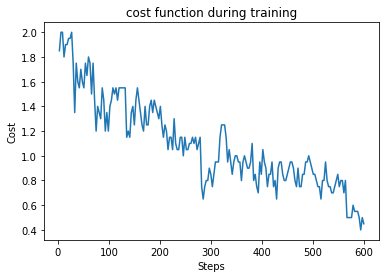

In [27]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("cost function during training")
plt.show()

In [28]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]
    #print(circuits)

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    prediction = [classification(results.get_counts(c)) for c in circuits]
    
    print(labels)
    print(prediction)
    accuracy = 0
    for i, p in enumerate(prediction):
        #if (p and labels[i]) or (not p and not labels[i]):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [29]:
acc = []
for _ in range(ACC_COUNT):
    accuracy, prediction = func_accuracy(test_data, test_labels, opt_var1, self_encoding=True)
    print("Test set accuracy - {}".format(accuracy))
    acc += [accuracy]
print("Test set accuracy (mean) - {}".format(sum(acc)/ACC_COUNT))

[ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. -1.  1.]
[-1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, -1, 1]
Test set accuracy - 0.6666666666666666
[ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. -1.  1.]
[-1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, -1, 1]
Test set accuracy - 0.6666666666666666
[ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. -1.  1.]
[-1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, -1, 1]
Test set accuracy - 0.6666666666666666
[ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. -1.  1.]
[-1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1]
Test set accuracy - 0.7083333333333334
[ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. -1.  1.]
[-

## Cross Entropy Loss

### Parity method

In [30]:
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1, 1)).toarray()

In [31]:
def parity_classification(counts, shots=1024):
    probs = np.zeros(2)
    for bitstring, counts in counts.items():
        hw_parity = hamming_weight_parity(bitstring)
        probs[hw_parity] += counts/shots
    
    return probs
def hamming_weight_parity(bitstring):
    hamming_weight = sum([int(k) for k in bitstring])
    return hamming_weight % 2

def loss_function(y,y_hat):
    #print(y_hat)
    return np.sum(y*np.log(y_hat))

In [32]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    #thetas -> variational parameters
    #X dataset
    #Y labels

    #build circuits for each datapoint
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [parity_classification(results.get_counts(c)) for c in circuits]

    cost = -np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost: {cost}")
    
    return cost

In [33]:
opt_var, opt_value , parameters, costs, evaluations = train(qc,
                                                            encoding, 
                                                            ansatz,
                                                            train_data,
                                                            train_labels_oh,
                                                            self_encoding=True,
                                                            initial_point=opt_var)

Cost: 0.5886865825613702
Cost: 0.5893044034750308
Cost: 0.5913234377910235
Cost: 0.5696699932353982
Cost: 0.6072953799059213
Cost: 0.6009095406705194
Cost: 0.5984060883890516
Cost: 0.5778403822977121
Cost: 0.5997188255638364
Cost: 0.596221905566258
Cost: 0.584700952430171
Cost: 0.5850827103678921
Cost: 0.6035503586553752
Cost: 0.6005728395042164
Cost: 0.5910006464135142
Cost: 0.5998746195270452
Cost: 0.5800242982247783
Cost: 0.5825783933637654
Cost: 0.5912423694985879
Cost: 0.5871732876863399
Cost: 0.5891041487008681
Cost: 0.5821718783955102
Cost: 0.593462918078945
Cost: 0.595351538873637
Cost: 0.5756299829331442
Cost: 0.5829803033589089
Cost: 0.5896033874021516
Cost: 0.5809686548155139
Cost: 0.5752745781986232
Cost: 0.5898793937784997
Cost: 0.592471469019871
Cost: 0.5895773481942082
Cost: 0.5963969110252618
Cost: 0.6042740348184432
Cost: 0.5963273144468972
Cost: 0.6006288683670918
Cost: 0.6066321197013462
Cost: 0.6016893767157081
Cost: 0.5943734614606371
Cost: 0.5900093743195004
Cost:

Cost: 0.6684504595305429
Cost: 0.6507111531806752
Cost: 0.7032236175166151
Cost: 0.6313390899719528
Cost: 0.712651750015094
Cost: 0.7306539738193605
Cost: 0.6946147359400313
Cost: 0.7222338377612827
Cost: 0.721485951093786
Cost: 0.7139856597885255
Cost: 0.7162720175813415
Cost: 0.7029422685249511
Cost: 0.714696688718319
Cost: 0.7109378165334181
Cost: 0.7158567521035716
Cost: 0.699676701946682
Cost: 0.6948579512197857
Cost: 0.6992328795710511
Cost: 0.6847462766263901
Cost: 0.6901705254185709
Cost: 0.6704170876915634
Cost: 0.7036334727475857
Cost: 0.6720978474830814
Cost: 0.6761301289696318
Cost: 0.6653038871123582
Cost: 0.6658955426405939
Cost: 0.6694900804128153
Cost: 0.6682875915660494
Cost: 0.668486227512336
Cost: 0.6629794408685924
Cost: 0.6680333563734374
Cost: 0.6623491237136181
Cost: 0.6574255480271528
Cost: 0.6726651192866603
Cost: 0.6517253693243182
Cost: 0.6772007745833735
Cost: 0.6509614880554444
Cost: 0.6635291418480257
Cost: 0.6787831407466364
Cost: 0.662180507093904
Cost: 

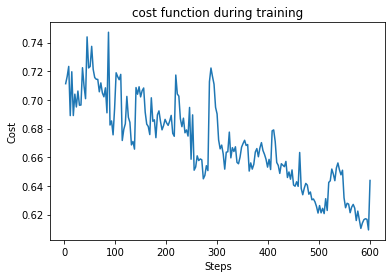

In [34]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("cost function during training")
plt.show()

In [35]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    probs = [parity_classification(results.get_counts(c)) for c in circuits]
    prediction = [-1 if p[0] > p[1] else 1 for p in probs]
    
    print(labels)
    print(prediction)
    accuracy = 0
    for i, p in enumerate(prediction):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [36]:
acc = []
for _ in range(ACC_COUNT):
    accuracy, prediction = func_accuracy(test_data, test_labels, opt_var, self_encoding=True)
    print("Test set accuracy - {}".format(accuracy))
    acc += [accuracy]
print("Test set accuracy (mean) - {}".format(sum(acc)/ACC_COUNT))

[ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. -1.  1.]
[1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, 1, -1, -1]
Test set accuracy - 0.5416666666666666
[ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. -1.  1.]
[1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, -1]
Test set accuracy - 0.5
[ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. -1.  1.]
[1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, 1, -1, -1]
Test set accuracy - 0.5416666666666666
[ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. -1.  1.]
[1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1]
Test set accuracy - 0.5833333333333334
[ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. -1.  1.]
[1, -1, -1, 1, 1, 1, -1, 1, 

In [37]:
print(len(train_data))

80


In [38]:
print(opt_value)
print(opt_var)

0.6364390849719856
[  7.58271775   3.39334921  12.98387923   4.17186716  -1.00606447
  -7.49870846   9.26536274 -12.81421085  -1.98174265  -5.9824032
   3.7388764    7.42629892  -2.32824148   9.57965194  -4.51444406
  -6.89399103   6.46887397 -15.8549446    1.35207535   9.77421608
  -6.17212277   1.69323682   1.55917378   9.04471124  -4.16700641
   9.42865145  -1.49987224   7.89259103  -5.64236639  -3.39332151]
